In [1]:
#mecab 
#from konlpy.tag import
#mecab = Mecab(dicpath=r"C:\mecab\mecab-ko-dic")

# 네이버 쇼핑 리뷰 감성 분류하기(Naver Shopping Review Sentiment Analysis)

---
출처 : https://wikidocs.net/94600

## 데이터 로드 및 분리

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from collections import Counter
from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [48]:
# 데이터로드 : link로부터 전체데이터(ratings_total.txt)다운
#urllib.request.urlretrieve("https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/naver_shopping.txt", filename="ratings_total.txt")

In [49]:
# 데이터에 열제목을 추가하여 pandas로 읽어옴
total_data = pd.read_table('ratings_total.txt', names=['ratings', 'reviews'])

print('전체 리뷰 개수 :',len(total_data)) # 전체 리뷰 개수 출력

전체 리뷰 개수 : 200000


In [50]:
total_data.head()

,ratings,reviews
0,5,배공빠르고 굿
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ


In [51]:
# 데이터의 레이블 생성. 1,2점 -> 0(부정) // 4,5점 ->1(긍정)
total_data['label'] = np.select([total_data.ratings > 3], [1], default=0)
total_data[:5]

,ratings,reviews,label
0,5,배공빠르고 굿,1
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고,0
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...,1
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...,0
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ,1


In [52]:
# 각 column별 중복확인
total_data['ratings'].nunique(), total_data['reviews'].nunique(), total_data['label'].nunique() 

(4, 199908, 2)

In [53]:
# 중복제거( review열에서 중복인 내용이 있으면 중복을 제거함)
total_data.drop_duplicates(subset=['reviews'], inplace=True)
print('총 샘플 수 : ', len(total_data))

총 샘플 수 :  199908


In [54]:
# NuLL값 확인, False면 null값이 존재 하지 않음
total_data.isnull().values.any()

False

In [55]:
# train_data, test_data 3:1로 분리함.

In [56]:
train_data, test_data = train_test_split(total_data, test_size=0.25, random_state=42)
print('train 수 : ', len(train_data))
print('test 수 : ', len(test_data))

train 수 :  149931
test 수 :  49977


   label  count
0      0  74918
1      1  75013


<AxesSubplot:>

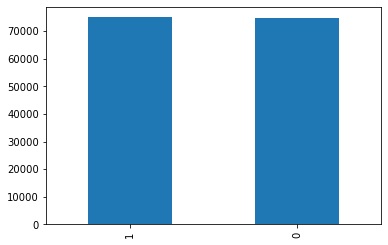

In [57]:
# train data 레이블 분포 확인
print(train_data.groupby('label').size().reset_index(name='count'))
train_data['label'].value_counts().plot(kind = 'bar')

## 데이터 정제

In [58]:
# 한글과 공백을 제외하고 모두 제거
train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-히-ㅣ가-힣]","")
train_data['reviews'].replace('',np.nan, inplace=True) #공백을 np.nan으로 대체
train_data = train_data.dropna(how='any') # null 제거
print(train_data.isnull().sum())

C:\Users\denni\.conda\envs\web\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


ratings    0
reviews    0
label      0
dtype: int64


C:\Users\denni\.conda\envs\web\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\denni\.conda\envs\web\lib\site-packages\pandas\core\series.py:4485: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


In [59]:
test_data.drop_duplicates(subset = ['reviews'], inplace=True) # 중복 제거
test_data['reviews'] = test_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['reviews'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 49977


C:\Users\denni\.conda\envs\web\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\denni\.conda\envs\web\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  
C:\Users\denni\.conda\envs\web\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\denni\.conda\envs\web\lib\site-packages\pandas\core\series.py:4485: SettingWithCopyWarning: 
A value

## 토큰화

In [60]:
# mecab을 이용하여 자름
mecab = Mecab(dicpath=r"C:\mecab\mecab-ko-dic")
print(mecab.morphs('와 이런 것도 상품이라고 차라리 내가 만드는 게 나을 뻔'))

['와', '이런', '것', '도', '상품', '이', '라고', '차라리', '내', '가', '만드', '는', '게', '나을', '뻔']


In [61]:
# 불용어 지정
f = open('stopword.txt','r', encoding='utf8')
lines = f.readlines()
stopwords = list(map(lambda s: s.strip(),lines))
stopwords = stopwords + ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게']

In [62]:
train_data['tokenized'] = train_data['reviews'].apply(mecab.morphs)
train_data['tokenized'] = train_data['tokenized'].apply(lambda x : [item for item in x if item not in stopwords])

In [63]:
test_data['tokenized'] = test_data['reviews'].apply(mecab.morphs)
test_data['tokenized'] = test_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

## 단어와 길이 분포 확인하기

In [64]:
negative_words = np.hstack(train_data[train_data.label == 0]['tokenized'].values)
positive_words = np.hstack(train_data[train_data.label == 1]['tokenized'].values)

In [65]:
negative_word_count = Counter(negative_words)
print(negative_word_count.most_common(20))

[('네요', 29672), ('는데', 19748), ('안', 18773), ('어요', 13793), ('있', 12923), ('너무', 12570), ('했', 11490), ('좋', 9459), ('배송', 9448), ('같', 8628), ('구매', 8539), ('거', 8376), ('없', 8261), ('되', 8128), ('아요', 8048), ('그냥', 7923), ('않', 7754), ('잘', 7572), ('만', 6418), ('요', 6301)]


In [66]:
positive_word_count = Counter(positive_words)
print(positive_word_count.most_common(20))

[('좋', 38595), ('아요', 20195), ('네요', 18967), ('잘', 18030), ('어요', 17888), ('구매', 15795), ('있', 12210), ('배송', 11935), ('는데', 11436), ('했', 9644), ('합니다', 9543), ('먹', 9453), ('재', 9063), ('너무', 8147), ('같', 7638), ('만족', 7065), ('거', 6261), ('쓰', 6169), ('기', 6078), ('사용', 5759)]


긍정 리뷰의 평균 길이 : 11.809886286377028
부정 리뷰의 평균 길이 : 14.651952801729891


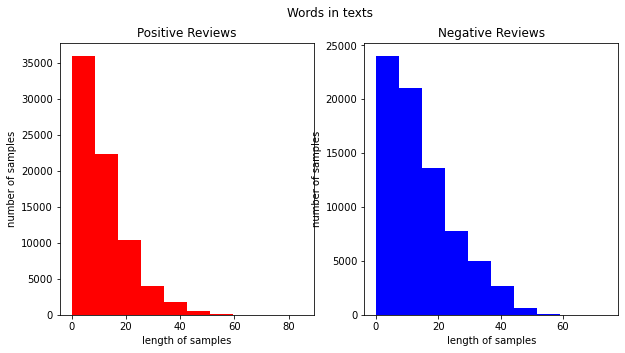

In [67]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
text_len = train_data[train_data['label']==1]['tokenized'].map(lambda x: len(x))
ax1.hist(text_len, color='red')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('length of samples')
ax1.set_ylabel('number of samples')
print('긍정 리뷰의 평균 길이 :', np.mean(text_len))

text_len = train_data[train_data['label']==0]['tokenized'].map(lambda x: len(x))
ax2.hist(text_len, color='blue')
ax2.set_title('Negative Reviews')
fig.suptitle('Words in texts')
ax2.set_xlabel('length of samples')
ax2.set_ylabel('number of samples')
print('부정 리뷰의 평균 길이 :', np.mean(text_len))
plt.show()

In [68]:
# 독립변수, 종속변수 나눔
X_train = train_data['tokenized'].values
y_train = train_data['label'].values
X_test= test_data['tokenized'].values
y_test = test_data['label'].values

In [70]:
#X_train

array([list(['사이즈', '센치', '씩', '늘린', '건데', '작', '아요', '색상', '완전', '달라요', '칙칙', '핑크', '네요', 'ㅠㅠ많이아쉽지만암막효과는좋아요']),
       list(['ㅂ', '불', '만족', '빗이', '픔멍이피부에빗질못해주겟네요']),
       list(['제품', '쓰', '만', '변기', '물', '잘', '안', '내려갔', '어요', '혹시나', '해서', '다시', '빼', '보', '니', '물', '다시', '잘', '내려가', '네요이', '많', '걸', '어쩌', '나요', '반품', '싶']),
       ..., list(['장', '주문', '안', '됩니다', '장', '가능']),
       list(['하림', '치킨', '서', '구입', '니', '엄청', '저렴', '네요', '배송', '쾅', '꽝', '얼', '어서', '도착', '아주', '만족', '합니다', 'ㅋㅋ']),
       list(['약해', '보이', '는데', '저렴', '잘', '삿', '어요'])], dtype=object)

In [72]:
#np.save('token_fit_data.npy',X_train)
# tokenizer set을 위해 fitdata 저장

## 정수 인코딩

In [25]:
# 훈련 데이터에 대해서 단어 집합 만들기
# 단어집합 생성시 각 단어에 고유한 정수 부여됨
# tokenizer.word_index를 출력하여 확인 가능
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [26]:
# 등장 횟수가 1회인 단어들은 배제하기 위해 단어들의 비중확인
threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 51296
등장 빈도가 1번 이하인 희귀 단어의 수: 28021
단어 집합에서 희귀 단어의 비율: 54.626091703056765
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.4126407170836714


In [27]:
# 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거.
# 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 23277


In [29]:
'''
이제 단어 집합의 크기는 21,787개입니다. 
이를 토크나이저의 인자로 넘겨주면, 
토크나이저는 텍스트 시퀀스를 숫자 시퀀스로 변환합니다. 
이러한 정수 인코딩 과정에서 이보다 큰 숫자가 부여된 단어들은 
OOV로 변환하겠습니다.
'''

tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [30]:
# 정수 토큰화가 되었는지 확인
print(X_train[:3])
print()
print(X_test[:3])

[[53, 1952, 250, 14761, 217, 58, 6, 137, 110, 708, 2929, 560, 2, 1], [407, 358, 42, 8490, 1], [35, 22, 29, 2318, 152, 7, 10, 7993, 4, 1174, 25, 113, 274, 36, 48, 152, 113, 7, 1800, 1882, 91, 136, 1317, 282, 99, 111]]

[[13, 619, 675, 93, 160, 208], [287, 3731, 52, 4040, 1527], [11, 55, 2, 40, 131, 3, 14, 6, 495, 241, 525, 48, 7, 2]]


## 패딩 : 서로 다른 길이의 샘플들의 길이를 동일하게 맞춰줌

리뷰의 최대 길이 : 85
리뷰의 평균 길이 : 13.230019142138717


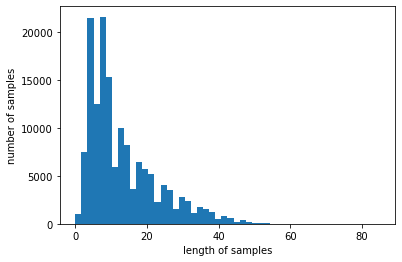

In [31]:
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [32]:
# 전체적으로 60이하의 길이를 가지고, 최대 85의 길이를 가진다.
# 만약 80으로 패딩할 경우 몇개를 온전히 보전할 수 있는지 확인

In [33]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

max_len = 80
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 80 이하인 샘플의 비율: 99.99933302652553


In [34]:
# 훈련용 리뷰의 99.99%가 80이하의 길이를 가지므로 훈련용 리뷰를 길이 80으로 패딩
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

## GRU로 네이버 쇼핑 리뷰 감성 분류하기

In [35]:
from tensorflow.keras.layers import Embedding, Dense, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(GRU(128))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)# 학습모델 저장

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=60, validation_split=0.2)

Epoch 1/15
1999/2000 [============================>.] - ETA: 0s - loss: 0.2941 - acc: 0.8851
Epoch 00001: val_acc improved from -inf to 0.90316, saving model to best_model.h5
2000/2000 [==============================] - 141s 71ms/step - loss: 0.2941 - acc: 0.8851 - val_loss: 0.2477 - val_acc: 0.9032
Epoch 2/15
1999/2000 [============================>.] - ETA: 0s - loss: 0.2367 - acc: 0.9106
Epoch 00002: val_acc improved from 0.90316 to 0.91200, saving model to best_model.h5
2000/2000 [==============================] - 146s 73ms/step - loss: 0.2367 - acc: 0.9106 - val_loss: 0.2299 - val_acc: 0.9120
Epoch 3/15
1999/2000 [============================>.] - ETA: 0s - loss: 0.2181 - acc: 0.9179
Epoch 00003: val_acc improved from 0.91200 to 0.91486, saving model to best_model.h5
2000/2000 [==============================] - 147s 74ms/step - loss: 0.2181 - acc: 0.9179 - val_loss: 0.2249 - val_acc: 0.9149
Epoch 4/15
1999/2000 [============================>.] - ETA: 0s - loss: 0.2056 - acc: 0.923

In [36]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

1562/1562 [==============================] - 16s 10ms/step - loss: 0.2219 - acc: 0.9204

 테스트 정확도: 0.9204


In [37]:
def sentiment_predict(new_sentence):
  new_sentence = mecab.morphs(new_sentence) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(loaded_model.predict(pad_new)) # 예측
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.".format((1 - score) * 100))

In [38]:
sentiment_predict('이 상품 진짜 좋아요... 저는 강추합니다. 대박')

97.31% 확률로 긍정 리뷰입니다.


In [39]:
sentiment_predict('진짜 배송도 늦고 개짜증나네요. 뭐 이런 걸 상품이라고 만듬?')

99.52% 확률로 부정 리뷰입니다.


In [40]:
sentiment_predict('판매자님... 너무 짱이에요.. 대박나삼')

98.09% 확률로 긍정 리뷰입니다.


In [41]:
sentiment_predict('ㅁㄴㅇㄻㄴㅇㄻㄴㅇ리뷰쓰기도 귀찮아')

89.27% 확률로 부정 리뷰입니다.
